# RCP85 SSH regression

In [1]:
%load_ext autoreload
%autoreload 2
import xarray as xr 
import numpy as np  
import cftime
import datetime
import copy
import scipy.stats
from scipy import signal
from functools import partial
import glob
import dask
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.units as munits
from matplotlib.dates import ConciseDateConverter
munits.registry[cftime.DatetimeNoLeap] = ConciseDateConverter()
munits.registry[cftime.datetime] = ConciseDateConverter()
#from geocat.viz import util as gvutil
#import util
import cartopy
import xesmf as xe
#import xskillscore as xs
#cartopy.config['pre_existing_data_dir']='/ihesp/shared/cartopy_features'
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point
import matplotlib.ticker as mticker
%matplotlib inline

#from HRDPutils import calendar_utils as cal
#from HRDPutils import stat_utils as stat
#from HRDPutils import mapplot_utils as maps
#from HRDPutils import colorbar_utils as cbars
#from HRDPutils import io_utils as io
#from HRDPutils import regrid_utils as regrid

In [2]:
import dask
from dask.distributed import wait
dask.__version__

'2021.09.0'

## Create Dask Cluster

In [3]:
# Close out Dask Cluster and release workers:
# NOTE:  only run this cell to terminate Dask Cluster!
#cluster.close()
#client.close()

In [4]:
# Use this if computing annual means:
def get_ClusterClient():
    import dask
    from dask_jobqueue import PBSCluster
    from dask.distributed import Client
    cluster = PBSCluster(
        cores=1,
        memory='20GB',
        processes=1,
        queue='casper',
        resource_spec='select=1:ncpus=1:mem=50GB',
        project='NCGD0011',
        walltime='02:00:00',
        interface='ib0',)

    dask.config.set({
        'distributed.dashboard.link':
        'https://jupyterhub.hpc.ucar.edu/stable/user/{USER}/proxy/{port}/status',
        'array.slicing.split_large_chunks': True
    })
    client = Client(cluster)
    return cluster, client

cluster, client = get_ClusterClient()
cluster.scale(jobs=36) 

In [5]:
cluster

Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/fredc/proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.12.206.20:45224,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/fredc/proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


# Main Processing

In [6]:
datadir = '/glade/campaign/collections/cmip/CMIP6/iHESP/BRCP85/HR/B.E.13.BRCP85C5CN.ne120_t12.sehires38.003.sunway.CN_OFF/ocn/proc/tseries/month_1/'
fin = datadir+'B.E.13.BRCP85C5CN.ne120_t12.sehires38.003.sunway.CN_OFF.pop.h.nday1.SSH.*.nc'

ds = xr.open_mfdataset(fin,
                       #parallel=True, # use dask to read in parallel
                       combine="nested",  # combine files in order provided
                       concat_dim="time",  # concatentate files along time dimension
                       data_vars="minimal",  # only concatentate data variables with "time" dimension
                       coords="minimal",  # same as above for coordinate variables
                       compat="override",
                       #preprocess=preprocess, # run this function on each dataset first before combining
                       #chunks={"nlat": "auto", "nlon": "auto"}, # choose simple
                       chunks={"time": 1}, # choose simple
                      )

In [7]:
%%time
# get POP grid
infile='/glade/work/fredc/metric/grid/POP_tx0.1v3_grid.nc'
dsg = xr.open_dataset(infile)
tlon = dsg.TLONG.persist()
tlat = dsg.TLAT.persist()
tarea = dsg.TAREA.persist()
dzt = dsg.DZT.persist()
dzu = dsg.DZU.persist()
dxt = dsg.DXT.persist()
dyt = dsg.DYT.persist()
dxu = dsg.DXU.persist()
dyu = dsg.DYU.persist()
htn = dsg.HTN.persist()
hte = dsg.HTE.persist()
ht = dsg.HT.persist()
hu = dsg.HU.persist()

CPU times: user 20.9 ms, sys: 4.65 ms, total: 25.5 ms
Wall time: 226 ms


In [8]:
%%time
ssh = ds.SSH.where(ds.SSH!=-1)
ssh = ssh * 10. #in mm
ssh['TLONG'] = tlon
ssh['TLAT'] = tlat
ssh = ssh.isel(nlon=slice(0,1000), nlat=slice(1000,2000))

CPU times: user 9.4 ms, sys: 809 µs, total: 10.2 ms
Wall time: 10.3 ms


In [9]:
ssh['time'] = ssh.time - datetime.timedelta(0.5) #middle of the month

In [10]:
month_length = ssh.time.dt.days_in_month
wgts = month_length.groupby("time.year") / month_length.groupby("time.year").sum()

In [11]:
yssh = (ssh * wgts).resample(time="AS").sum(dim="time") / (xr.ones_like(ssh) * wgts).resample(time="AS").sum(dim="time")
yssh = yssh.where(yssh!=0)

In [12]:
cvdpf = '/glade/campaign/collections/cmip/CMIP6/iHESP/BRCP85/HR/B.E.13.BRCP85C5CN.ne120_t12.sehires38.003.sunway.CN_OFF/CVDP/CESM_HR_HF-TNST_#3.cvdp_data.2006-2100.nc'
ds2 = xr.open_dataset(cvdpf, decode_times=False)
ds2['time'] = ssh.time

/glade/work/fredc/miniconda3/envs/sparse/lib/python3.7/site-packages/xarray/conventions.py:520: SerializationWarning: variable 'sic_nh_extent_climo' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  decode_timedelta=decode_timedelta,
/glade/work/fredc/miniconda3/envs/sparse/lib/python3.7/site-packages/xarray/conventions.py:520: SerializationWarning: variable 'sic_sh_extent_climo' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  decode_timedelta=decode_timedelta,


In [13]:
amo_timeseries_mon = ds2.amo_timeseries_mon
amo_timeseries_yearly = (amo_timeseries_mon * wgts).resample(time="AS").sum(dim="time") / (xr.ones_like(amo_timeseries_mon) * wgts).resample(time="AS").sum(dim="time")
nam_timeseries_djf = ds2.nam_timeseries_djf.rename({'TIME':'time'})
nam_timeseries_djf['time'] = yssh.time 
nao_timeseries_djf = ds2.nao_timeseries_djf.rename({'TIME':'time'})
nao_timeseries_djf['time'] = yssh.time 
pna_timeseries_djf = ds2.pna_timeseries_djf.rename({'TIME':'time'})
pna_timeseries_djf['time'] = yssh.time 
npo_timeseries_djf = ds2.npo_timeseries_djf.rename({'TIME':'time'})
npo_timeseries_djf['time'] = yssh.time 
#sam_timeseries_ann = ds2.sam_timeseries_ann.rename({'TIME':'time'})
#sam_timeseries_ann['time'] = yssh.time 

pr_global_avg_djf = ds2.pr_global_avg_djf.rename({'TIME':'time'})
pr_global_avg_djf['time'] = yssh.time 
sic_nh_extent_djf = ds2.sic_nh_extent_djf.rename({'TIME':'time'})
sic_nh_extent_djf['time'] = yssh.time 

In [14]:
mocf = '/glade/campaign/collections/cmip/CMIP6/iHESP/BRCP85/HR/B.E.13.BRCP85C5CN.ne120_t12.sehires38.003.sunway.CN_OFF/ocn/proc/tseries/month_1/B.E.13.BRCP85C5CN.ne120_t12.sehires38.003.sunway.CN_OFF.pop.h.MOCz.200601.210012.nc'
ds3 = xr.open_dataset(mocf)
ds3['time'] = ssh.time

In [15]:
amoc = ds3.MOC.where(ds3.MOC.moc_z > 50000).sel(transport_reg=1).sel(moc_comp=0).max('moc_z').sel(lat_aux_grid=26.5, method="nearest")

In [16]:
yamoc = (amoc * wgts).resample(time="AS").sum(dim="time") / (xr.ones_like(amoc) * wgts).resample(time="AS").sum(dim="time")

In [17]:
yssh = yssh.assign_coords({'amo':amo_timeseries_yearly})
yssh = yssh.assign_coords({'nam':nam_timeseries_djf})
yssh = yssh.assign_coords({'nao':nao_timeseries_djf})
yssh = yssh.assign_coords({'pna':pna_timeseries_djf})
yssh = yssh.assign_coords({'npo':npo_timeseries_djf})
#yssh = yssh.assign_coords({'sam':sam_timeseries_ann})
yssh = yssh.assign_coords({'pr':pr_global_avg_djf})
yssh = yssh.assign_coords({'nh_sic':sic_nh_extent_djf})

yssh = yssh.assign_coords({'amoc':yamoc})

In [18]:
mask = xr.where(np.isnan(yssh.isel(time=0)),0,1).load()
tearea = tarea.isel(nlon=slice(0,1000), nlat=slice(1000,2000))
GoM_ssh = (yssh[:,360:520,120:210] * tearea[360:520,120:210]).sum(dim=['nlon','nlat']) / (mask[360:520,120:210] * tearea[360:520,120:210]).sum(dim=['nlon','nlat']) 

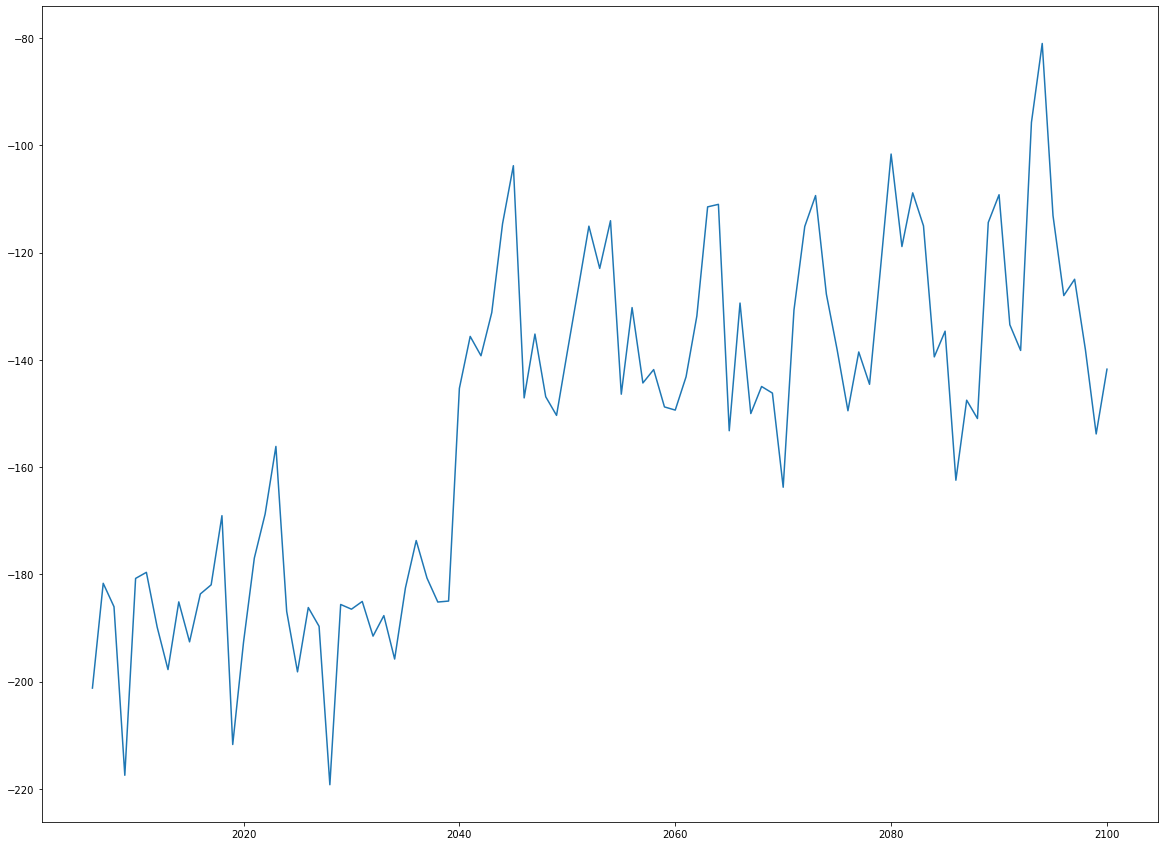

In [19]:
plt.figure(figsize=(20,15))
plt.plot(GoM_ssh.time, GoM_ssh)

In [20]:
polyfit = yssh.swap_dims({"time": "amo"}).polyfit(dim="amo", deg=1).compute()
amo_reg_ssh = polyfit.polyfit_coefficients.sel(degree=1)

/glade/work/fredc/miniconda3/envs/sparse/lib/python3.7/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/glade/work/fredc/miniconda3/envs/sparse/lib/python3.7/site-packages/cartopy/mpl/gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '
/glade/work/fredc/miniconda3/envs/sparse/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1598: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  shading=shading)


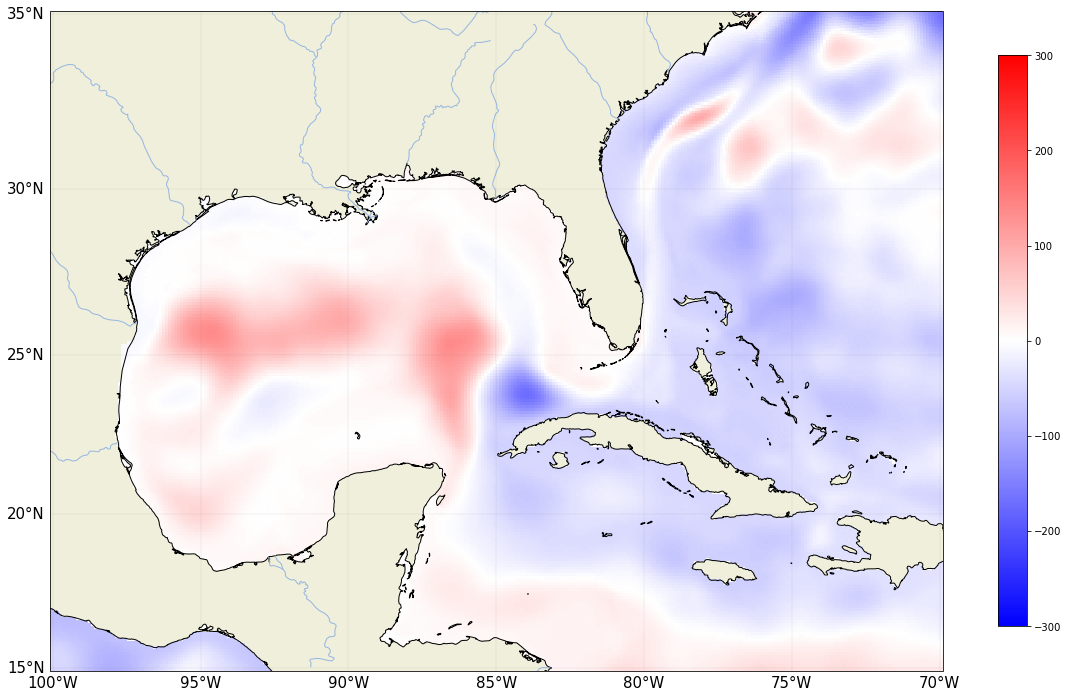

In [21]:
plt.figure(figsize=(20,15))

# the central_longitude parameter tells the projection where to be centered for this axes
ax = plt.axes(projection=ccrs.Mercator(central_longitude=-85.0))
gl = ax.gridlines(linewidth=0.2, color='gray', alpha=0.5, linestyle='-', draw_labels=True)

# we control what we actually see in the plot with this:
# We can set the extent using latitude and longitude, but then we need to tell it the projection, which is
# PlateCarree since that is equivalent
ax.set_extent([-100-0.1, -70+0.1, 15-0.1, 35+0.1], ccrs.PlateCarree())

# add geographic information
ax.add_feature(cartopy.feature.LAND)
#ax.add_feature(cartopy.feature.OCEAN)
ax.coastlines(resolution='10m')  # looks better with resolution='10m'
#ax.add_feature(cartopy.feature.BORDERS, linestyle='-', lw=.1)
ax.add_feature(cartopy.feature.RIVERS)

# Now we can add on lat/lon labels:
# more info: http://scitools.org.uk/cartopy/docs/v0.13/matplotlib/gridliner.html
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.ticker as mticker
# the following two make the labels look like lat/lon format
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlocator = mticker.FixedLocator([-100, -105, -95, -90, -85, -80, -75, -70])  # control where the ticks are
gl.ylocator = mticker.FixedLocator([15, 20, 25, 30, 35])  # control where the ticks are
gl.xlabel_style = {'size': 15,}  # control how the tick labels look
gl.ylabel_style = {'size': 15,}
gl.xlabels_top = False  # turn off labels where you don't want them
gl.ylabels_right = False

im = ax.pcolormesh(yssh.TLONG, yssh.TLAT, amo_reg_ssh, transform=ccrs.PlateCarree(), cmap=plt.cm.bwr)
plt.colorbar(im, shrink=0.7)
im.set_clim(-300, 300)

In [22]:
polyfit = yssh.swap_dims({"time": "yamoc"}).polyfit(dim="yamoc", deg=1).compute()
amoc_reg_ssh = polyfit.polyfit_coefficients.sel(degree=1)

/glade/work/fredc/miniconda3/envs/sparse/lib/python3.7/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/glade/work/fredc/miniconda3/envs/sparse/lib/python3.7/site-packages/cartopy/mpl/gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '
/glade/work/fredc/miniconda3/envs/sparse/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1598: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  shading=shading)


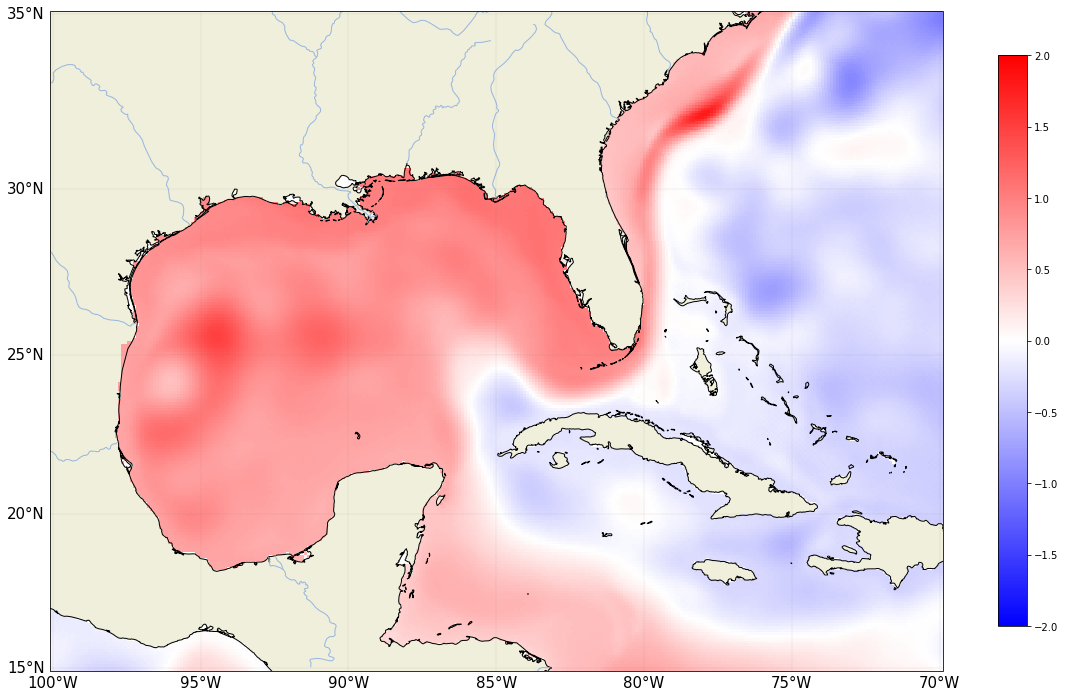

In [23]:
plt.figure(figsize=(20,15))

# the central_longitude parameter tells the projection where to be centered for this axes
ax = plt.axes(projection=ccrs.Mercator(central_longitude=-85.0))
gl = ax.gridlines(linewidth=0.2, color='gray', alpha=0.5, linestyle='-', draw_labels=True)

# we control what we actually see in the plot with this:
# We can set the extent using latitude and longitude, but then we need to tell it the projection, which is
# PlateCarree since that is equivalent
ax.set_extent([-100-0.1, -70+0.1, 15-0.1, 35+0.1], ccrs.PlateCarree())

# add geographic information
ax.add_feature(cartopy.feature.LAND)
#ax.add_feature(cartopy.feature.OCEAN)
ax.coastlines(resolution='10m')  # looks better with resolution='10m'
#ax.add_feature(cartopy.feature.BORDERS, linestyle='-', lw=.1)
ax.add_feature(cartopy.feature.RIVERS)

# Now we can add on lat/lon labels:
# more info: http://scitools.org.uk/cartopy/docs/v0.13/matplotlib/gridliner.html
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.ticker as mticker
# the following two make the labels look like lat/lon format
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlocator = mticker.FixedLocator([-100, -105, -95, -90, -85, -80, -75, -70])  # control where the ticks are
gl.ylocator = mticker.FixedLocator([15, 20, 25, 30, 35])  # control where the ticks are
gl.xlabel_style = {'size': 15,}  # control how the tick labels look
gl.ylabel_style = {'size': 15,}
gl.xlabels_top = False  # turn off labels where you don't want them
gl.ylabels_right = False

im = ax.pcolormesh(yssh.TLONG, yssh.TLAT, amoc_reg_ssh, transform=ccrs.PlateCarree(), cmap=plt.cm.bwr)
plt.colorbar(im, shrink=0.7)
im.set_clim(-2, 2)

In [24]:
polyfit = yssh.swap_dims({"time": "nam"}).polyfit(dim="nam", skipna=True, deg=1).compute()
nam_reg_ssh = polyfit.polyfit_coefficients.sel(degree=1)

/glade/work/fredc/miniconda3/envs/sparse/lib/python3.7/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/glade/work/fredc/miniconda3/envs/sparse/lib/python3.7/site-packages/cartopy/mpl/gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '
/glade/work/fredc/miniconda3/envs/sparse/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1598: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  shading=shading)


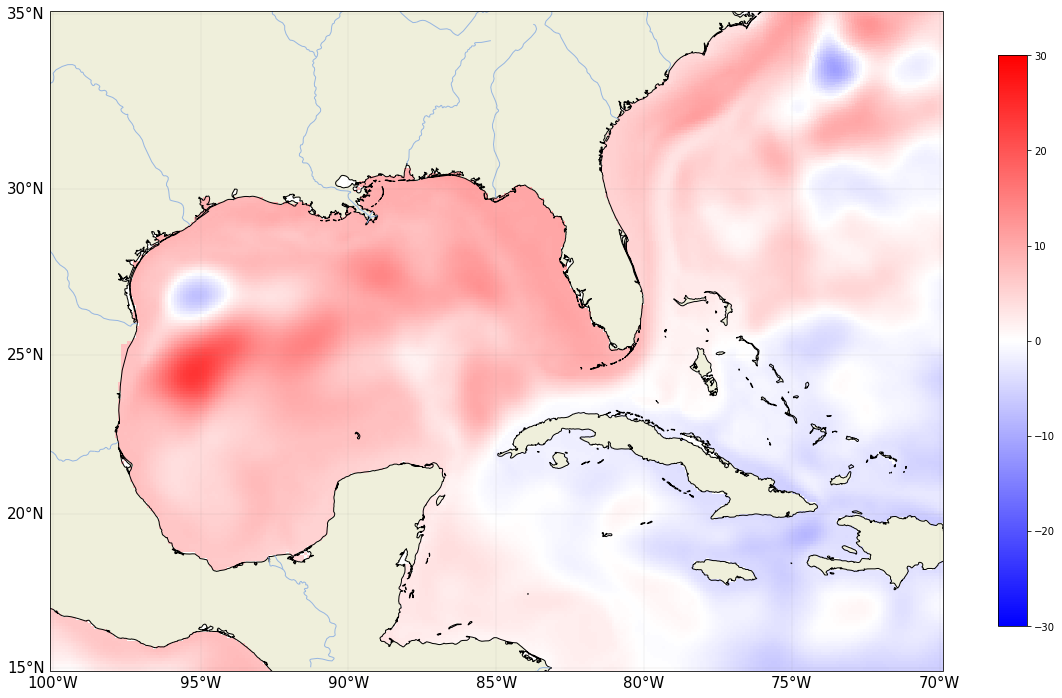

In [25]:
plt.figure(figsize=(20,15))

# the central_longitude parameter tells the projection where to be centered for this axes
ax = plt.axes(projection=ccrs.Mercator(central_longitude=-85.0))
gl = ax.gridlines(linewidth=0.2, color='gray', alpha=0.5, linestyle='-', draw_labels=True)

# we control what we actually see in the plot with this:
# We can set the extent using latitude and longitude, but then we need to tell it the projection, which is
# PlateCarree since that is equivalent
ax.set_extent([-100-0.1, -70+0.1, 15-0.1, 35+0.1], ccrs.PlateCarree())

# add geographic information
ax.add_feature(cartopy.feature.LAND)
#ax.add_feature(cartopy.feature.OCEAN)
ax.coastlines(resolution='10m')  # looks better with resolution='10m'
#ax.add_feature(cartopy.feature.BORDERS, linestyle='-', lw=.1)
ax.add_feature(cartopy.feature.RIVERS)

# Now we can add on lat/lon labels:
# more info: http://scitools.org.uk/cartopy/docs/v0.13/matplotlib/gridliner.html
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.ticker as mticker
# the following two make the labels look like lat/lon format
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlocator = mticker.FixedLocator([-100, -105, -95, -90, -85, -80, -75, -70])  # control where the ticks are
gl.ylocator = mticker.FixedLocator([15, 20, 25, 30, 35])  # control where the ticks are
gl.xlabel_style = {'size': 15,}  # control how the tick labels look
gl.ylabel_style = {'size': 15,}
gl.xlabels_top = False  # turn off labels where you don't want them
gl.ylabels_right = False

im = ax.pcolormesh(yssh.TLONG, yssh.TLAT, nam_reg_ssh, transform=ccrs.PlateCarree(), cmap=plt.cm.bwr)
plt.colorbar(im, shrink=0.7)
im.set_clim(-30, 30)

In [26]:
polyfit = yssh.swap_dims({"time": "nao"}).polyfit(dim="nao", deg=1).compute()
nao_reg_ssh = polyfit.polyfit_coefficients.sel(degree=1)

/glade/work/fredc/miniconda3/envs/sparse/lib/python3.7/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/glade/work/fredc/miniconda3/envs/sparse/lib/python3.7/site-packages/cartopy/mpl/gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '
/glade/work/fredc/miniconda3/envs/sparse/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1598: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  shading=shading)


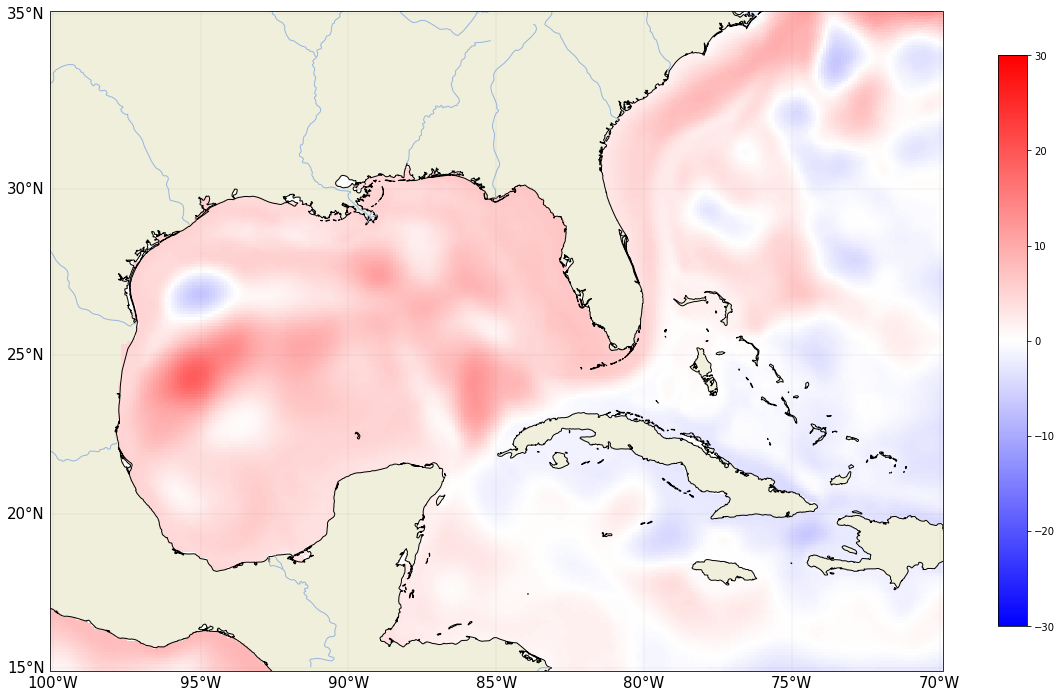

In [27]:
plt.figure(figsize=(20,15))

# the central_longitude parameter tells the projection where to be centered for this axes
ax = plt.axes(projection=ccrs.Mercator(central_longitude=-85.0))
gl = ax.gridlines(linewidth=0.2, color='gray', alpha=0.5, linestyle='-', draw_labels=True)

# we control what we actually see in the plot with this:
# We can set the extent using latitude and longitude, but then we need to tell it the projection, which is
# PlateCarree since that is equivalent
ax.set_extent([-100-0.1, -70+0.1, 15-0.1, 35+0.1], ccrs.PlateCarree())

# add geographic information
ax.add_feature(cartopy.feature.LAND)
#ax.add_feature(cartopy.feature.OCEAN)
ax.coastlines(resolution='10m')  # looks better with resolution='10m'
#ax.add_feature(cartopy.feature.BORDERS, linestyle='-', lw=.1)
ax.add_feature(cartopy.feature.RIVERS)

# Now we can add on lat/lon labels:
# more info: http://scitools.org.uk/cartopy/docs/v0.13/matplotlib/gridliner.html
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.ticker as mticker
# the following two make the labels look like lat/lon format
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlocator = mticker.FixedLocator([-100, -105, -95, -90, -85, -80, -75, -70])  # control where the ticks are
gl.ylocator = mticker.FixedLocator([15, 20, 25, 30, 35])  # control where the ticks are
gl.xlabel_style = {'size': 15,}  # control how the tick labels look
gl.ylabel_style = {'size': 15,}
gl.xlabels_top = False  # turn off labels where you don't want them
gl.ylabels_right = False

im = ax.pcolormesh(yssh.TLONG, yssh.TLAT, nao_reg_ssh, transform=ccrs.PlateCarree(), cmap=plt.cm.bwr)
plt.colorbar(im, shrink=0.7)
im.set_clim(-30, 30)

In [28]:
polyfit = yssh.swap_dims({"time": "pna"}).polyfit(dim="pna", deg=1).compute()
pna_reg_ssh = polyfit.polyfit_coefficients.sel(degree=1)

/glade/work/fredc/miniconda3/envs/sparse/lib/python3.7/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/glade/work/fredc/miniconda3/envs/sparse/lib/python3.7/site-packages/cartopy/mpl/gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '
/glade/work/fredc/miniconda3/envs/sparse/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1598: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  shading=shading)


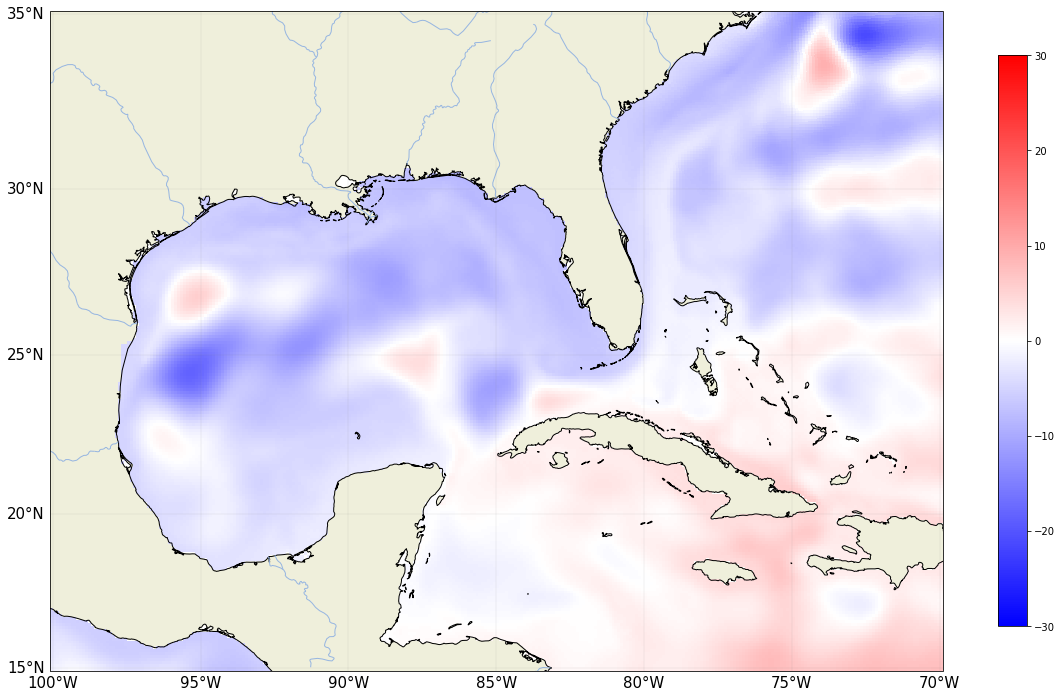

In [29]:
plt.figure(figsize=(20,15))

# the central_longitude parameter tells the projection where to be centered for this axes
ax = plt.axes(projection=ccrs.Mercator(central_longitude=-85.0))
gl = ax.gridlines(linewidth=0.2, color='gray', alpha=0.5, linestyle='-', draw_labels=True)

# we control what we actually see in the plot with this:
# We can set the extent using latitude and longitude, but then we need to tell it the projection, which is
# PlateCarree since that is equivalent
ax.set_extent([-100-0.1, -70+0.1, 15-0.1, 35+0.1], ccrs.PlateCarree())

# add geographic information
ax.add_feature(cartopy.feature.LAND)
#ax.add_feature(cartopy.feature.OCEAN)
ax.coastlines(resolution='10m')  # looks better with resolution='10m'
#ax.add_feature(cartopy.feature.BORDERS, linestyle='-', lw=.1)
ax.add_feature(cartopy.feature.RIVERS)

# Now we can add on lat/lon labels:
# more info: http://scitools.org.uk/cartopy/docs/v0.13/matplotlib/gridliner.html
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.ticker as mticker
# the following two make the labels look like lat/lon format
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlocator = mticker.FixedLocator([-100, -105, -95, -90, -85, -80, -75, -70])  # control where the ticks are
gl.ylocator = mticker.FixedLocator([15, 20, 25, 30, 35])  # control where the ticks are
gl.xlabel_style = {'size': 15,}  # control how the tick labels look
gl.ylabel_style = {'size': 15,}
gl.xlabels_top = False  # turn off labels where you don't want them
gl.ylabels_right = False

im = ax.pcolormesh(yssh.TLONG, yssh.TLAT, pna_reg_ssh, transform=ccrs.PlateCarree(), cmap=plt.cm.bwr)
plt.colorbar(im, shrink=0.7)
im.set_clim(-30, 30)

In [30]:
polyfit = yssh.swap_dims({"time": "npo"}).polyfit(dim="npo", deg=1).compute()
npo_reg_ssh = polyfit.polyfit_coefficients.sel(degree=1)

/glade/work/fredc/miniconda3/envs/sparse/lib/python3.7/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/glade/work/fredc/miniconda3/envs/sparse/lib/python3.7/site-packages/cartopy/mpl/gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '
/glade/work/fredc/miniconda3/envs/sparse/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1598: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  shading=shading)


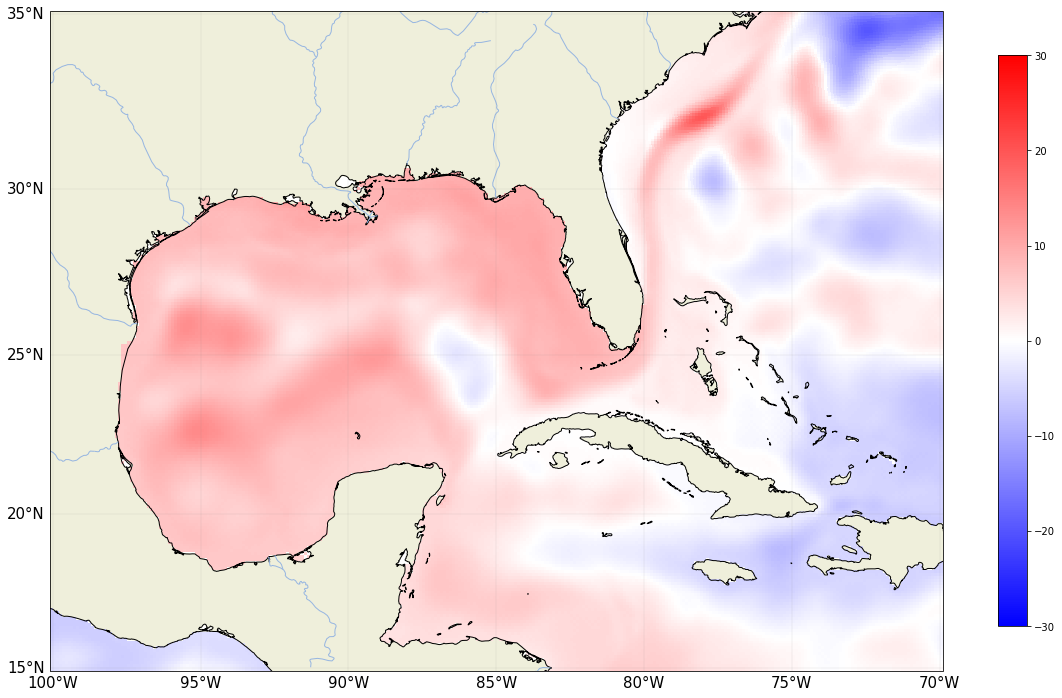

In [31]:
plt.figure(figsize=(20,15))

# the central_longitude parameter tells the projection where to be centered for this axes
ax = plt.axes(projection=ccrs.Mercator(central_longitude=-85.0))
gl = ax.gridlines(linewidth=0.2, color='gray', alpha=0.5, linestyle='-', draw_labels=True)

# we control what we actually see in the plot with this:
# We can set the extent using latitude and longitude, but then we need to tell it the projection, which is
# PlateCarree since that is equivalent
ax.set_extent([-100-0.1, -70+0.1, 15-0.1, 35+0.1], ccrs.PlateCarree())

# add geographic information
ax.add_feature(cartopy.feature.LAND)
#ax.add_feature(cartopy.feature.OCEAN)
ax.coastlines(resolution='10m')  # looks better with resolution='10m'
#ax.add_feature(cartopy.feature.BORDERS, linestyle='-', lw=.1)
ax.add_feature(cartopy.feature.RIVERS)

# Now we can add on lat/lon labels:
# more info: http://scitools.org.uk/cartopy/docs/v0.13/matplotlib/gridliner.html
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.ticker as mticker
# the following two make the labels look like lat/lon format
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlocator = mticker.FixedLocator([-100, -105, -95, -90, -85, -80, -75, -70])  # control where the ticks are
gl.ylocator = mticker.FixedLocator([15, 20, 25, 30, 35])  # control where the ticks are
gl.xlabel_style = {'size': 15,}  # control how the tick labels look
gl.ylabel_style = {'size': 15,}
gl.xlabels_top = False  # turn off labels where you don't want them
gl.ylabels_right = False

im = ax.pcolormesh(yssh.TLONG, yssh.TLAT, npo_reg_ssh, transform=ccrs.PlateCarree(), cmap=plt.cm.bwr)
plt.colorbar(im, shrink=0.7)
im.set_clim(-30, 30)

In [32]:
polyfit = yssh.swap_dims({"time": "pr"}).polyfit(dim="pr", deg=1).compute()
pr_reg_ssh = polyfit.polyfit_coefficients.sel(degree=1)

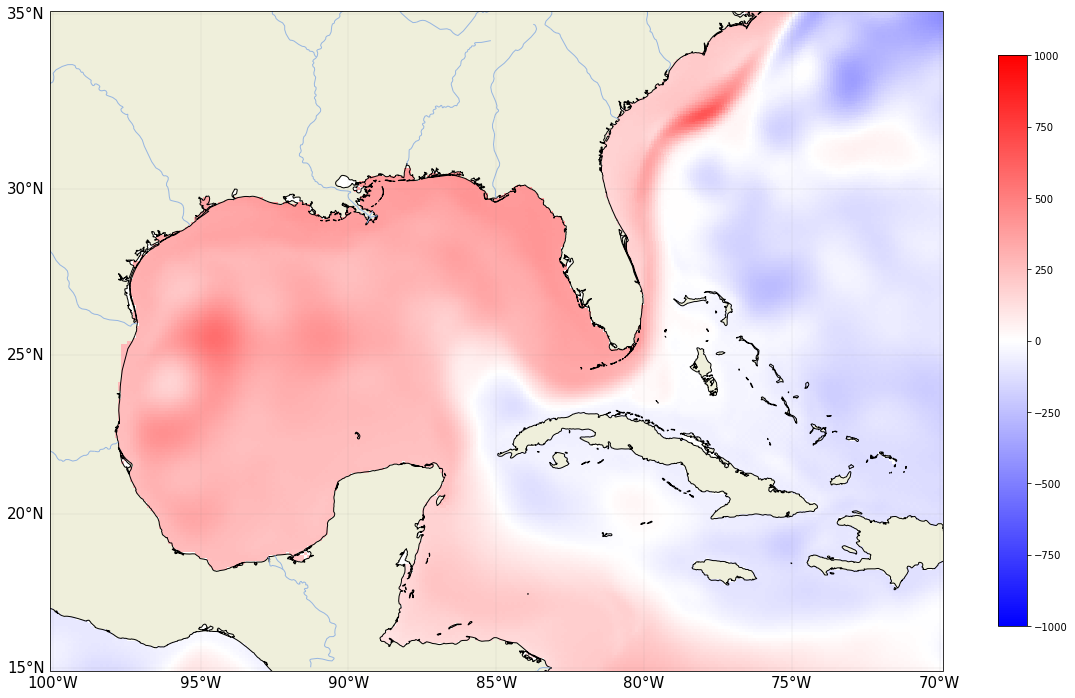

In [43]:
plt.figure(figsize=(20,15))

# the central_longitude parameter tells the projection where to be centered for this axes
ax = plt.axes(projection=ccrs.Mercator(central_longitude=-85.0))
gl = ax.gridlines(linewidth=0.2, color='gray', alpha=0.5, linestyle='-', draw_labels=True)

# we control what we actually see in the plot with this:
# We can set the extent using latitude and longitude, but then we need to tell it the projection, which is
# PlateCarree since that is equivalent
ax.set_extent([-100-0.1, -70+0.1, 15-0.1, 35+0.1], ccrs.PlateCarree())

# add geographic information
ax.add_feature(cartopy.feature.LAND)
#ax.add_feature(cartopy.feature.OCEAN)
ax.coastlines(resolution='10m')  # looks better with resolution='10m'
#ax.add_feature(cartopy.feature.BORDERS, linestyle='-', lw=.1)
ax.add_feature(cartopy.feature.RIVERS)

# Now we can add on lat/lon labels:
# more info: http://scitools.org.uk/cartopy/docs/v0.13/matplotlib/gridliner.html
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.ticker as mticker
# the following two make the labels look like lat/lon format
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlocator = mticker.FixedLocator([-100, -105, -95, -90, -85, -80, -75, -70])  # control where the ticks are
gl.ylocator = mticker.FixedLocator([15, 20, 25, 30, 35])  # control where the ticks are
gl.xlabel_style = {'size': 15,}  # control how the tick labels look
gl.ylabel_style = {'size': 15,}
gl.xlabels_top = False  # turn off labels where you don't want them
gl.ylabels_right = False

im = ax.pcolormesh(yssh.TLONG, yssh.TLAT, pr_reg_ssh, transform=ccrs.PlateCarree(), cmap=plt.cm.bwr)
plt.colorbar(im, shrink=0.7)
im.set_clim(-1000, 1000)

In [34]:
polyfit = yssh[1:].swap_dims({"time": "nh_sic"}).polyfit(dim="nh_sic", deg=1).compute()
nh_sic_reg_ssh = polyfit.polyfit_coefficients.sel(degree=1)

/glade/work/fredc/miniconda3/envs/sparse/lib/python3.7/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/glade/work/fredc/miniconda3/envs/sparse/lib/python3.7/site-packages/cartopy/mpl/gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '
/glade/work/fredc/miniconda3/envs/sparse/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1598: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  shading=shading)


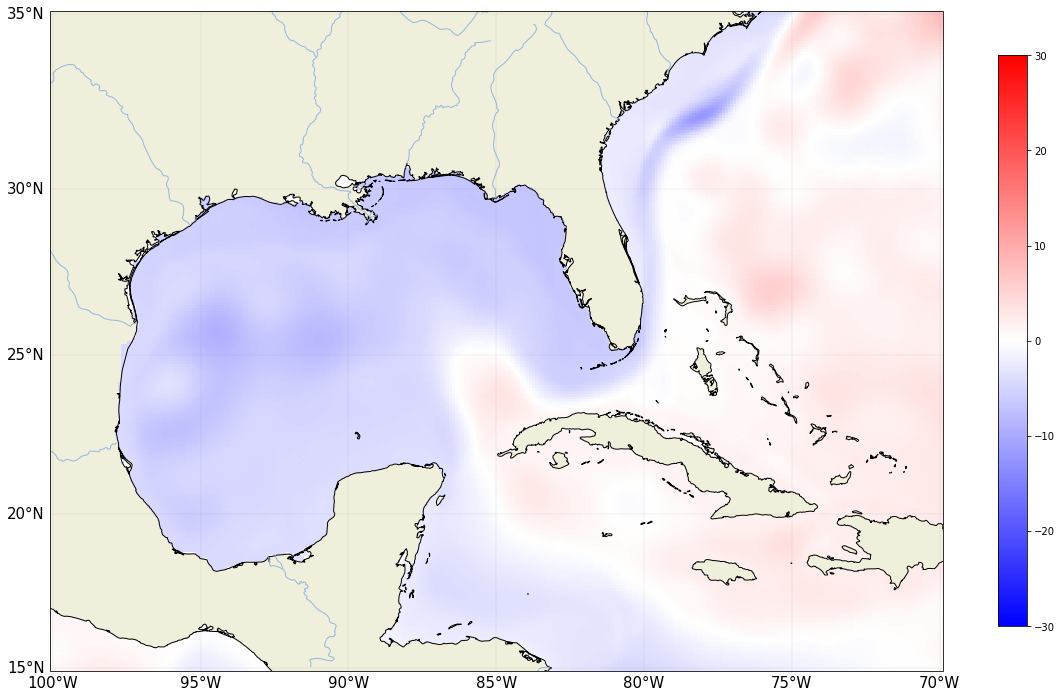

In [35]:
plt.figure(figsize=(20,15))

# the central_longitude parameter tells the projection where to be centered for this axes
ax = plt.axes(projection=ccrs.Mercator(central_longitude=-85.0))
gl = ax.gridlines(linewidth=0.2, color='gray', alpha=0.5, linestyle='-', draw_labels=True)

# we control what we actually see in the plot with this:
# We can set the extent using latitude and longitude, but then we need to tell it the projection, which is
# PlateCarree since that is equivalent
ax.set_extent([-100-0.1, -70+0.1, 15-0.1, 35+0.1], ccrs.PlateCarree())

# add geographic information
ax.add_feature(cartopy.feature.LAND)
#ax.add_feature(cartopy.feature.OCEAN)
ax.coastlines(resolution='10m')  # looks better with resolution='10m'
#ax.add_feature(cartopy.feature.BORDERS, linestyle='-', lw=.1)
ax.add_feature(cartopy.feature.RIVERS)

# Now we can add on lat/lon labels:
# more info: http://scitools.org.uk/cartopy/docs/v0.13/matplotlib/gridliner.html
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.ticker as mticker
# the following two make the labels look like lat/lon format
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlocator = mticker.FixedLocator([-100, -105, -95, -90, -85, -80, -75, -70])  # control where the ticks are
gl.ylocator = mticker.FixedLocator([15, 20, 25, 30, 35])  # control where the ticks are
gl.xlabel_style = {'size': 15,}  # control how the tick labels look
gl.ylabel_style = {'size': 15,}
gl.xlabels_top = False  # turn off labels where you don't want them
gl.ylabels_right = False

im = ax.pcolormesh(yssh.TLONG, yssh.TLAT, nh_sic_reg_ssh, transform=ccrs.PlateCarree(), cmap=plt.cm.bwr)
plt.colorbar(im, shrink=0.7)
im.set_clim(-30, 30)

In [36]:
def pvalue_array(x,y,dname):
    x_an=x-x.mean(dname)
    slope=((x_an)*(y-y.mean(dname))).sum(dname)/((x_an)*(x_an)).sum(dname)
    interc=y.mean(dname)-slope*x.mean(dname)
    ypred=slope*x+interc  
    n=len(x[dname])
    mse=np.sqrt(((y-ypred)**2).sum(dname)/(n-2))
    xsq=np.sqrt(((x_an)**2).sum(dname))
    standerr=mse/xsq
    pval=2*(1-t.cdf(np.abs(slope/standerr),n-2))
    pval=xr.DataArray(pval,dims=standerr.dims,coords=standerr.coords)
    return pval

def rvalue_array(x,y,dname):  
    xmean=x.mean(dname)
    ymean=y.mean(dname)
    numer=(x*y).mean(dname)-xmean*ymean
    denom=np.sqrt(((x**2).mean(dname)-xmean**2)*                  (((y**2).mean(dname))-(ymean**2)))
    return numer/denom

def regcoeff_array(x,y,dname):
    x_an=x-x.mean(dname)
    y_an=y-y.mean(dname)
    slope=(x_an*y_an).sum(dname)/(x_an*x_an).sum(dname)
    return slope

In [37]:
regcoeff=regcoeff_array(amo_timeseries_yearly,yssh,'time')
#rvalues=rvalue_array(tseries,spatial,'time')
#pvalues=pvalue_array(tseries,spatial,'time')

/glade/work/fredc/miniconda3/envs/sparse/lib/python3.7/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/glade/work/fredc/miniconda3/envs/sparse/lib/python3.7/site-packages/cartopy/mpl/gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '
/glade/work/fredc/miniconda3/envs/sparse/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1598: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  shading=shading)


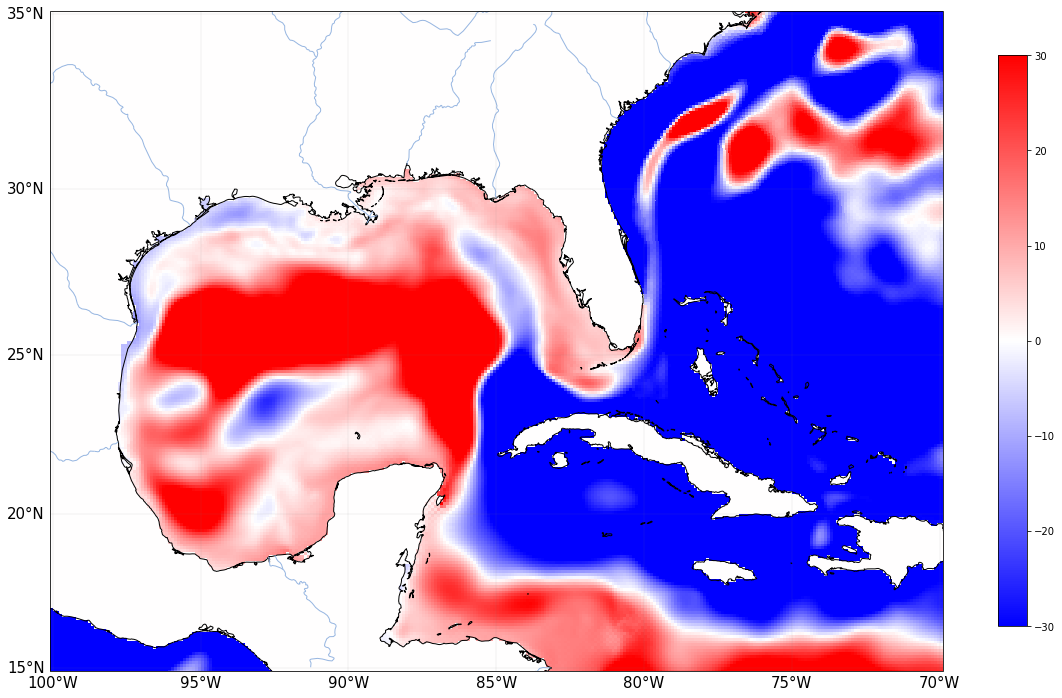

In [38]:
plt.figure(figsize=(20,15))

# the central_longitude parameter tells the projection where to be centered for this axes
ax = plt.axes(projection=ccrs.Mercator(central_longitude=-85.0))
gl = ax.gridlines(linewidth=0.2, color='gray', alpha=0.5, linestyle='-', draw_labels=True)

# we control what we actually see in the plot with this:
# We can set the extent using latitude and longitude, but then we need to tell it the projection, which is
# PlateCarree since that is equivalent
ax.set_extent([-100-0.1, -70+0.1, 15-0.1, 35+0.1], ccrs.PlateCarree())

# add geographic information
ax.add_feature(cartopy.feature.LAND)
#ax.add_feature(cartopy.feature.OCEAN)
ax.coastlines(resolution='10m')  # looks better with resolution='10m'
#ax.add_feature(cartopy.feature.BORDERS, linestyle='-', lw=.1)
ax.add_feature(cartopy.feature.RIVERS)

# Now we can add on lat/lon labels:
# more info: http://scitools.org.uk/cartopy/docs/v0.13/matplotlib/gridliner.html
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.ticker as mticker
# the following two make the labels look like lat/lon format
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlocator = mticker.FixedLocator([-100, -105, -95, -90, -85, -80, -75, -70])  # control where the ticks are
gl.ylocator = mticker.FixedLocator([15, 20, 25, 30, 35])  # control where the ticks are
gl.xlabel_style = {'size': 15,}  # control how the tick labels look
gl.ylabel_style = {'size': 15,}
gl.xlabels_top = False  # turn off labels where you don't want them
gl.ylabels_right = False

im = ax.pcolormesh(yssh.TLONG, yssh.TLAT, regcoeff, transform=ccrs.PlateCarree(), cmap=plt.cm.bwr)
plt.colorbar(im, shrink=0.7)
im.set_clim(-30, 30)

In [39]:
yssh.where(np.isnan(yssh.nh_sic)==False)

<xarray.DataArray (time: 95, nlat: 1000, nlon: 1000)>
dask.array<where, shape=(95, 1000, 1000), dtype=float64, chunksize=(1, 1000, 1000), chunktype=numpy.ndarray>
Coordinates: (12/16)
  * time               (time) object 2006-01-01 00:00:00 ... 2100-01-01 00:00:00
    TLAT               (nlat, nlon) float64 -17.86 -17.86 -17.86 ... 68.77 68.77
    TLONG              (nlat, nlon) float64 -109.9 -109.9 ... -5.981 -5.842
    ULAT               (nlat, nlon) float64 -17.81 -17.81 -17.81 ... 68.8 68.79
    ULONG              (nlat, nlon) float64 -109.9 -109.8 ... -5.899 -5.76
    amo                (time) float64 -0.2277 -0.1312 -0.1947 ... 0.2447 0.02267
    ...                 ...
    pr                 (time) float64 -0.1142 -0.101 -0.1093 ... 0.107 0.1482
    nh_sic             (time) float32 nan 12.57 12.3 ... 0.7917 1.325 1.117
    lat_aux_grid       float32 26.27
    moc_components     |S256 b'Eulerian Mean'
    transport_regions  |S256 b'Atlantic Ocean + Mediterranean Sea + Labrador ...
    amoc               (time) float64 19.01 18.18 18.86 ... 10.29 11.92 11.61
Dimensions without coordinates: nlat, nlon

In [40]:
np.where(np.isnan(yssh.nh_sic)!=False)

(array([0]),)

In [41]:
polyfit = yssh.swap_dims({"time": "sam"}).polyfit(dim="sam", deg=1).compute()
sam_reg_ssh = polyfit.polyfit_coefficients.sel(degree=1)

/glade/work/fredc/miniconda3/envs/sparse/lib/python3.7/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/glade/work/fredc/miniconda3/envs/sparse/lib/python3.7/site-packages/cartopy/mpl/gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '
/glade/work/fredc/miniconda3/envs/sparse/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1598: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  shading=shading)


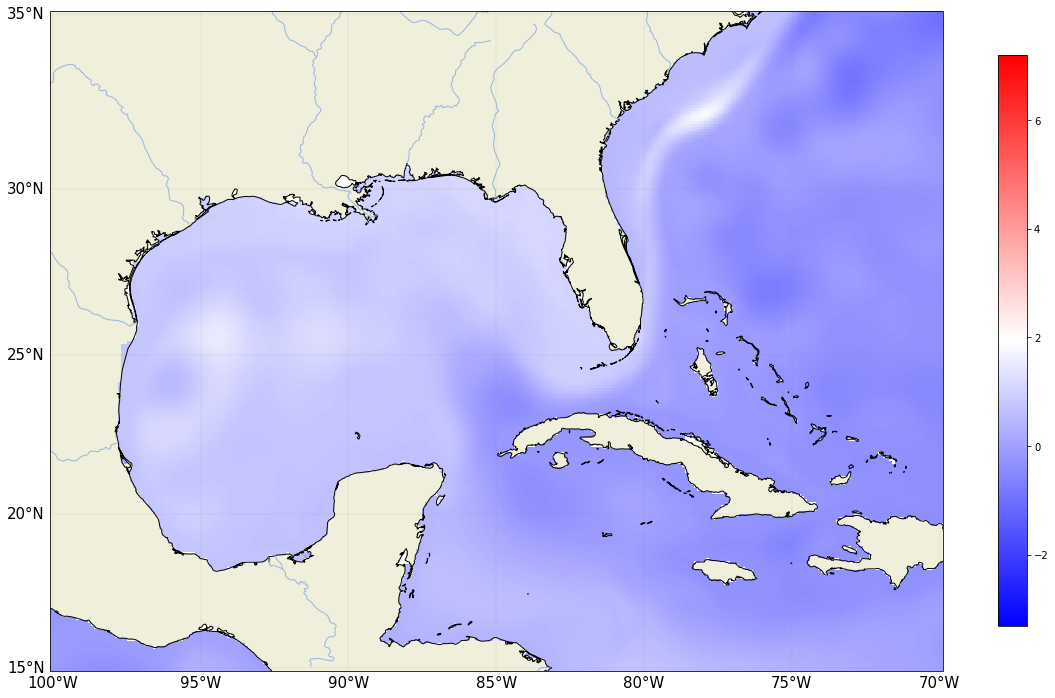

In [42]:
plt.figure(figsize=(20,15))

# the central_longitude parameter tells the projection where to be centered for this axes
ax = plt.axes(projection=ccrs.Mercator(central_longitude=-85.0))
gl = ax.gridlines(linewidth=0.2, color='gray', alpha=0.5, linestyle='-', draw_labels=True)

# we control what we actually see in the plot with this:
# We can set the extent using latitude and longitude, but then we need to tell it the projection, which is
# PlateCarree since that is equivalent
ax.set_extent([-100-0.1, -70+0.1, 15-0.1, 35+0.1], ccrs.PlateCarree())

# add geographic information
ax.add_feature(cartopy.feature.LAND)
#ax.add_feature(cartopy.feature.OCEAN)
ax.coastlines(resolution='10m')  # looks better with resolution='10m'
#ax.add_feature(cartopy.feature.BORDERS, linestyle='-', lw=.1)
ax.add_feature(cartopy.feature.RIVERS)

# Now we can add on lat/lon labels:
# more info: http://scitools.org.uk/cartopy/docs/v0.13/matplotlib/gridliner.html
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.ticker as mticker
# the following two make the labels look like lat/lon format
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlocator = mticker.FixedLocator([-100, -105, -95, -90, -85, -80, -75, -70])  # control where the ticks are
gl.ylocator = mticker.FixedLocator([15, 20, 25, 30, 35])  # control where the ticks are
gl.xlabel_style = {'size': 15,}  # control how the tick labels look
gl.ylabel_style = {'size': 15,}
gl.xlabels_top = False  # turn off labels where you don't want them
gl.ylabels_right = False

im = ax.pcolormesh(yssh.TLONG, yssh.TLAT, sam_reg_ssh, transform=ccrs.PlateCarree(), cmap=plt.cm.bwr)
plt.colorbar(im, shrink=0.7)
#im.set_clim(-30, 30)

In [44]:
ls /glade/campaign/collections/cmip/CMIP6/iHESP/BRCP85/HR/B.E.13.BRCP85C5CN.ne120_t12.sehires38.003.sunway.CN_OFF/ocn/proc/tseries/month_1/

B.E.13.BRCP85C5CN.ne120_t12.sehires38.003.sunway.CN_OFF.pop.h.DIA_IMPVF_TEMP.206901-206912.nc
B.E.13.BRCP85C5CN.ne120_t12.sehires38.003.sunway.CN_OFF.pop.h.DIA_IMPVF_TEMP.207001-207012.nc
B.E.13.BRCP85C5CN.ne120_t12.sehires38.003.sunway.CN_OFF.pop.h.DIA_IMPVF_TEMP.207101-207112.nc
B.E.13.BRCP85C5CN.ne120_t12.sehires38.003.sunway.CN_OFF.pop.h.DIA_IMPVF_TEMP.207201-207212.nc
B.E.13.BRCP85C5CN.ne120_t12.sehires38.003.sunway.CN_OFF.pop.h.DIA_IMPVF_TEMP.207301-207312.nc
B.E.13.BRCP85C5CN.ne120_t12.sehires38.003.sunway.CN_OFF.pop.h.DIA_IMPVF_TEMP.207401-207412.nc
B.E.13.BRCP85C5CN.ne120_t12.sehires38.003.sunway.CN_OFF.pop.h.DIA_IMPVF_TEMP.207501-207512.nc
B.E.13.BRCP85C5CN.ne120_t12.sehires38.003.sunway.CN_OFF.pop.h.DIA_IMPVF_TEMP.207601-207612.nc
B.E.13.BRCP85C5CN.ne120_t12.sehires38.003.sunway.CN_OFF.pop.h.DIA_IMPVF_TEMP.207701-207712.nc
B.E.13.BRCP85C5CN.ne120_t12.sehires38.003.sunway.CN_OFF.pop.h.DIA_IMPVF_TEMP.207801-207812.nc
B.E.13.BRCP85C5CN.ne120_t12.sehires38.003.sunway.CN_OFF.pop.